Model saved as safetensors: diffusion_pytorch_model.safetensors
Safetensors model loaded successfully.


  5%|▍         | 48/1000 [00:03<01:09, 13.63it/s]

'Image at step 50'

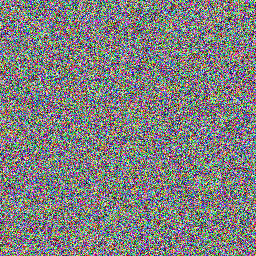

 10%|▉         | 98/1000 [00:07<01:04, 14.00it/s]

'Image at step 100'

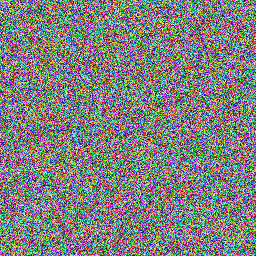

 15%|█▍        | 148/1000 [00:11<01:00, 14.19it/s]

'Image at step 150'

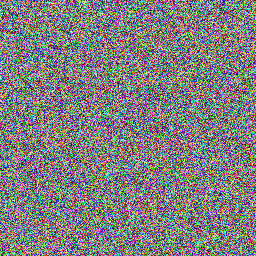

 20%|█▉        | 199/1000 [00:14<00:56, 14.16it/s]

'Image at step 200'

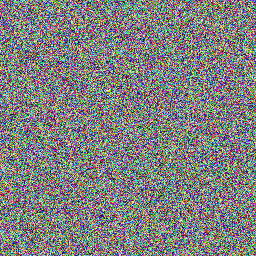

 25%|██▍       | 249/1000 [00:18<00:52, 14.24it/s]

'Image at step 250'

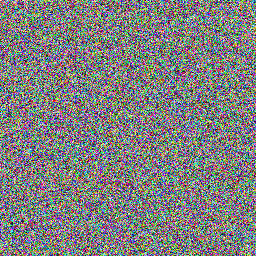

 30%|██▉       | 299/1000 [00:22<00:49, 14.21it/s]

'Image at step 300'

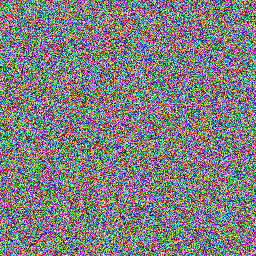

 35%|███▍      | 349/1000 [00:25<00:46, 13.90it/s]

'Image at step 350'

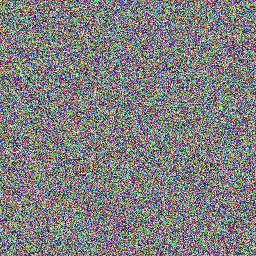

 40%|███▉      | 399/1000 [00:29<00:42, 13.99it/s]

'Image at step 400'

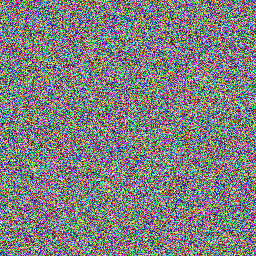

 45%|████▍     | 449/1000 [00:32<00:39, 14.12it/s]

'Image at step 450'

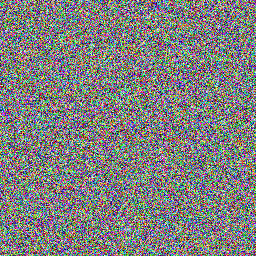

 50%|████▉     | 499/1000 [00:36<00:35, 14.15it/s]

'Image at step 500'

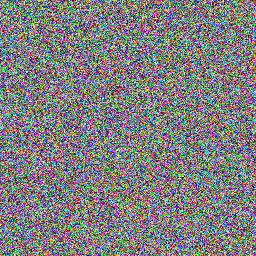

 55%|█████▍    | 549/1000 [00:40<00:32, 13.83it/s]

'Image at step 550'

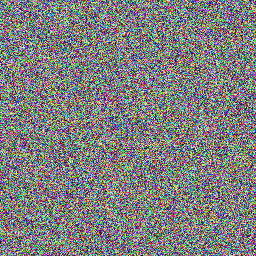

 60%|█████▉    | 599/1000 [00:43<00:28, 14.07it/s]

'Image at step 600'

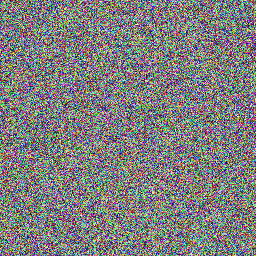

 65%|██████▍   | 649/1000 [00:47<00:24, 14.05it/s]

'Image at step 650'

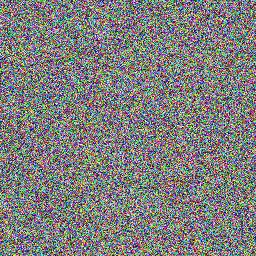

 70%|██████▉   | 699/1000 [00:50<00:21, 13.99it/s]

'Image at step 700'

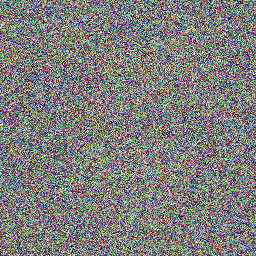

 75%|███████▍  | 749/1000 [00:54<00:17, 14.10it/s]

'Image at step 750'

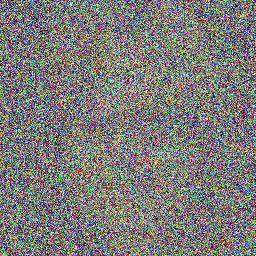

 80%|███████▉  | 799/1000 [00:58<00:14, 14.07it/s]

'Image at step 800'

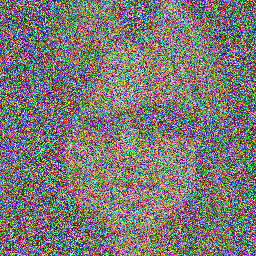

 85%|████████▍ | 849/1000 [01:01<00:10, 14.14it/s]

'Image at step 850'

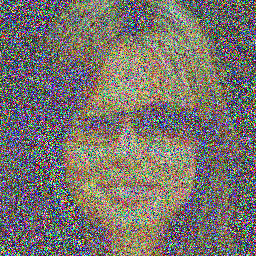

 90%|████████▉ | 899/1000 [01:05<00:07, 13.98it/s]

'Image at step 900'

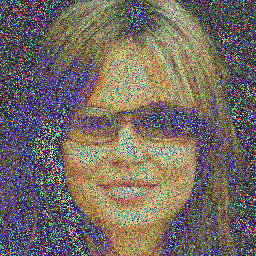

 95%|█████████▍| 949/1000 [01:08<00:03, 13.97it/s]

'Image at step 950'

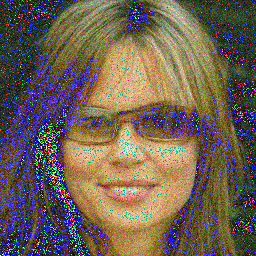

100%|█████████▉| 999/1000 [01:12<00:00, 13.89it/s]

'Image at step 1000'

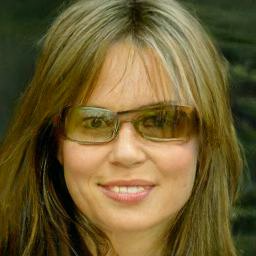

100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


'Denoising complete.'

In [19]:
import torch
from diffusers import UNet2DModel, DDPMScheduler
from safetensors.torch import save_file, load_file
import tqdm
import PIL.Image
import numpy as np
import os

# 1. 初始化原始模型
repo_id = "google/ddpm-celebahq-256"
model = UNet2DModel.from_pretrained(repo_id, use_safetensors=False)  # 加載原始模型
model.to("cuda")  # 將模型移至 GPU

# 2. 將模型保存為 safetensors 格式
safetensors_file = "diffusion_pytorch_model.safetensors"
save_file(model.state_dict(), safetensors_file)
print(f"Model saved as safetensors: {safetensors_file}")

# 3. 測試從 safetensors 文件加載模型
state_dict = load_file(safetensors_file)  # 加載 safetensors 文件
model.load_state_dict(state_dict)  # 將權重加載到模型中
print("Safetensors model loaded successfully.")

# 測試模型的推理過程
# 4. 初始化調度器
scheduler = DDPMScheduler.from_pretrained(repo_id)

# 5. 創建高斯噪聲
torch.manual_seed(0)
noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size).to("cuda")

# 6. 定義顯示圖片的函數
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

def save_sample(sample, i):
    # 檢查目錄是否存在，若不存在則創建
    output_dir = "ddpm-celebahq-256"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 處理圖像
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    # 儲存圖片
    image_pil = PIL.Image.fromarray(image_processed[0])
    filename = f"{output_dir}/image_step_{i}.png"
    image_pil.save(filename)
    return filename

# 8. 逆擴散過程
sample = noisy_sample
for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. 預測噪聲殘差
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. 計算較少噪聲的圖片，並將 x_t -> x_t-1
    sample = scheduler.step(residual, t, sample).prev_sample

    # 3. 選擇性顯示圖片（每 50 步顯示一次）
    if (i + 1) % 50 == 0:
        display_sample(sample, i + 1)
        save_sample(sample, i + 1)

display("Denoising complete.")

In [55]:
from huggingface_hub import login
from huggingface_hub import whoami
from dotenv import load_dotenv
import os

# 加載 .env 文件
load_dotenv()

# 獲取 Hugging Face Token
hf_token = os.getenv("HF_TOKEN")

# 輸入您的 Hugging Face 訪問令牌
login(token=hf_token)
user_info = whoami()
print(user_info)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


{'type': 'user', 'id': '66146f19df4aeb48d0492970', 'name': 'Mou11209203', 'fullname': 'Mou Chen', 'email': 'M11209203@mail.ntust.edu.tw', 'emailVerified': True, 'canPay': False, 'periodEnd': 1735689599, 'isPro': False, 'avatarUrl': '/avatars/2285e7bc1f6a90359706afec8d33e5c5.svg', 'orgs': [{'type': 'org', 'id': '637b7eb9d8f5500105212ddc', 'name': 'ntust', 'fullname': 'National Taiwan University of Science and Technology', 'email': None, 'canPay': False, 'periodEnd': None, 'avatarUrl': 'https://www.gravatar.com/avatar/977b6b9dc1e7d2339375cf56c4d4d3e8?d=retro&size=100', 'roleInOrg': 'contributor', 'isEnterprise': False}], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'diffusion', 'role': 'write', 'createdAt': '2024-12-09T20:37:23.972Z'}}}


In [23]:
from huggingface_hub import create_repo
repo_name = "ddpm-celebahq-256"
create_repo(repo_name)

HfHubHTTPError: 409 Client Error: Conflict for url: https://huggingface.co/api/repos/create (Request ID: Root=1-67576017-68651eef3851a0fc1dac1c4d;6d04934c-5881-4a88-8244-d8b9299eed8a)

You already created this model repo

In [25]:
from huggingface_hub import HfApi

api = HfApi()
model_repo_id = "Mou11209203/ddpm-celebahq-256"  # 修改為您的模型名稱
safetensors_file_path = safetensors_file

# 上傳 safetensors 文件
api.upload_file(
    path_or_fileobj=safetensors_file_path,
    path_in_repo="diffusion_pytorch_model.safetensors",
    repo_id=model_repo_id,
    repo_type="model"
)

print(f"Safetensors file uploaded to Hugging Face: {model_repo_id}")


diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

Safetensors file uploaded to Hugging Face: Mou11209203/ddpm-celebahq-256


In [56]:
from huggingface_hub import upload_file
# 目標 Hugging Face 存儲庫名稱
repo_id = "Mou11209203/ddpm-celebahq-256"

# 上傳圖片檔案
image_dir = "ddpm-celebahq-256-DDPM"  # 存放圖片的資料夾
for img_file in os.listdir(image_dir):
    if img_file.endswith(".png"):
        upload_file(
            path_or_fileobj=os.path.join(image_dir, img_file),
            path_in_repo=f"images/DDPM/{img_file}",
            repo_id=repo_id,
        )
print("DDPM Images files uploaded successfully!")

DDPM Images files uploaded successfully!


In [ ]:
from huggingface_hub import upload_file
# 目標 Hugging Face 存儲庫名稱
repo_id = "Mou11209203/ddpm-celebahq-256"

# 上傳圖片檔案
image_dir = "ddpm-celebahq-256-DDIM"  # 存放圖片的資料夾
for img_file in os.listdir(image_dir):
    if img_file.endswith(".png"):
        upload_file(
            path_or_fileobj=os.path.join(image_dir, img_file),
            path_in_repo=f"images/DDIM/{img_file}",
            repo_id=repo_id,
        )
print("DDIM Images files uploaded successfully!")

DDIM Images files uploaded successfully!


In [58]:
from huggingface_hub import upload_file
# 目標 Hugging Face 存儲庫名稱
repo_id = "Mou11209203/ddpm-celebahq-256"

# 上傳圖片檔案
image_dir = "ddpm-celebahq-256-PNDM"  # 存放圖片的資料夾
for img_file in os.listdir(image_dir):
    if img_file.endswith(".png"):
        upload_file(
            path_or_fileobj=os.path.join(image_dir, img_file),
            path_in_repo=f"images/PNDM/{img_file}",
            repo_id=repo_id,
        )
print("PNDM Images files uploaded successfully!")

PNDM Images files uploaded successfully!


In [51]:
# 上傳 README 文件
upload_file(
    path_or_fileobj=image_dir + "/README.md",
    path_in_repo="README.md",
    repo_id=repo_id,
)
print("README file uploaded successfully!")

README file uploaded successfully!


In [52]:
# 上傳 config.json 文件
upload_file(
    path_or_fileobj=image_dir + "/config.json",
    path_in_repo="config.json",
    repo_id=repo_id,
)
print("Config file uploaded successfully!")

No files have been modified since last commit. Skipping to prevent empty commit.


Config file uploaded successfully!


In [53]:
from huggingface_hub import upload_file
# 目標 Hugging Face 存儲庫名稱
repo_id = "Mou11209203/ddpm-celebahq-256"

# 上傳 scheduler_config.json 文件
upload_file(
    path_or_fileobj="ddpm-celebahq-256\scheduler_config.json",  # 本地文件的路徑
    path_in_repo="scheduler_config.json",  # 文件儲存到 Hugging Face 存儲庫的位置
    repo_id=repo_id,  # 存儲庫 ID
)

print("scheduler_config.json uploaded successfully!")


No files have been modified since last commit. Skipping to prevent empty commit.


scheduler_config.json uploaded successfully!


In [54]:
repo_id = "Mou11209203/ddpm-celebahq-256"
# 上傳 environment.yml 文件
upload_file(
    path_or_fileobj="./environment.yml",  # 本地文件的路徑
    path_in_repo="environment.yml",  # 文件儲存到 Hugging Face 存儲庫的位置
    repo_id=repo_id,  # 存儲庫 ID
)

print("environment.yml uploaded successfully!")

No files have been modified since last commit. Skipping to prevent empty commit.


environment.yml uploaded successfully!
